In [1]:
import os
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn import metrics
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from collections import Counter
import itertools

[nltk_data] Downloading package stopwords to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Load in the dictionary dataset into a pandas df
data_path = os.path.join(os.getcwd(), 'data', 'dictionary.txt')
dic = pd.read_csv(data_path, sep='|', header=None)

# ...and do the same with the sentiment_labels data
data_path = os.path.join(os.getcwd(), 'data', 'sentiment_labels.txt')
cents = pd.read_csv(data_path, sep='|')

dic = dic.rename(columns={0: "feature", 1: "ID"})# We rename the columns
# dic = dic.rename(index={range(239232)})
dic = dic.sort_values(by="ID") # We change the order of the rows to be sorted by ID number
movie_data = dic[["ID", "feature"]] # We change the order of the columns and change the name of the the df

# We make an array of the sentiments (already in the right order) and add it to our df
y = np.array(cents.iloc[:, -1])
movie_data.insert(2, "sentiment", y)

phrase_data = movie_data.sort_index()
phrase_data.drop("ID",axis=1,inplace=True)
phrase_data.insert(2,"label",0)

print(phrase_data.head())

       feature  sentiment  label
0            !    0.50000      0
1          ! '    0.52778      0
2         ! ''    0.50000      0
3       ! Alas    0.44444      0
4  ! Brilliant    0.86111      0


In [3]:
### We create a smaller subsample of the dataset - to speed up the computation when working on our code

# specify a smaller number of reviews
small_N = 2390

# choose small_N random and distinct integers between 0 and 239231
rand = random.sample(range(239231), small_N)

# find these indices in the original dictionary - and make a new array of them
rand_sample = phrase_data.iloc[rand]

rand_sample.head()

,feature,sentiment,label
85637,banter-filled comedy,0.65278,0
189235,slip into hokum . A Rumor of Angels does n't j...,0.44444,0
165101,of dealing with the subject,0.50000,0
68420,a precise and moving portrait of someone,0.79167,0
232814,wholesale ineptitude,0.40278,0


In [4]:
### We can use the random sample or the full data set going forward

phrases = phrase_data
# phrases = rand_sample

In [5]:
### add correct labels based on sentiment column (uses qualities of numpy for efficiency)

np_phrase = np.array(phrases) # make it a numpy array

# create a series of boolean masks
vpos = (0.8 < np_phrase[:, 1]).astype(int)
pos =  (0.6 < np_phrase[:, 1]).astype(int)
ntrl = (0.4 < np_phrase[:, 1]).astype(int)
neg = (0.2 < np_phrase[:, 1]).astype(int)
vneg = (0 <= np_phrase[:, 1]).astype(int)

# add the masks together to get the correct label numbers for each review based on sentiment value
labels = vneg + neg + ntrl + pos + vpos - 1

# make a binary label class
binary_labels = (0.5 >= np_phrase[:, 1]).astype(int)

# update the array with our new values
# np_phrase[:, 2] = labels
np_phrase[:, 2] = binary_labels

# change back to a pandas
phrases = pd.DataFrame(np_phrase)

In [6]:
print(len(binary_labels[binary_labels == 0])/len(binary_labels[binary_labels == 1]))

0.7980473652960143


In [7]:
# I'm commenting the below out cus it takes ages to run and ive got the model and embedding saved :)

In [8]:
import pickle
### we are going to train our embedding model on the original review corpus
### in the hope to capture more semantic information
lemmatize = WordNetLemmatizer()
# opening the file in read mode and reading the file
orig_snip = open("original_rt_snippets.txt")
orig_snip = orig_snip.read()

# spliting into separate lists for each line in the txt file
orig_snip = orig_snip.split("\n")

# looping over each review
for i in range(len(orig_snip)):
    
    orig_snip[i] = orig_snip[i].lower() # lower case
    
    orig_snip[i] = re.sub(r'[^\w]', " ", orig_snip[i]) # remove all special characters
    orig_snip[i] = re.sub(r'[\d]', " ", orig_snip[i]) # ...and numbers
    
    orig_snip[i] = nltk.word_tokenize(orig_snip[i]) # make each word an individual string, thus each review is a sublist
    
    orig_snip[i] = [word for word in orig_snip[i] if word not in stopwords.words("english")] # removing stop-words
    orig_snip[i] = [lemmatize.lemmatize(word) for word in orig_snip[i]] # lemmatizing (converting to the grammatical root)

with open("clean_snippets.pkl", "wb") as file:
    pickle.dump(orig_snip, file)
    file.close()

In [40]:
orig_snip_clean_edit = orig_snip.copy() # copying the data to save having to run the last chunk again

In [41]:
### We are going to remove the 50 most frequent words from the corpus - this should make our embedding more accurate
topmost = 50

word_counts = Counter(itertools.chain.from_iterable(orig_snip_clean_edit))  # counting each word in the corpus
words_most_freq = [k for k, v in word_counts.most_common(topmost)] # getting a list of the top 50

for i in range(len(orig_snip_clean_edit)): # looping over each review
    
    # Remove the most frequent words
    orig_snip_clean_edit[i] = [word for word in orig_snip_clean_edit[i] if word not in words_most_freq]

In [42]:
# importing genism modules and setting up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# create our model, specifying our hyperparameters
word2vec = gensim.models.Word2Vec(orig_snip_clean_edit, epochs=3, min_count=5, window=3, vector_size=500)

# saving the model
word2vec.save('word2vec_model')

2022-11-20 20:04:35,813 : INFO : collecting all words and their counts
2022-11-20 20:04:35,813 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-20 20:04:35,852 : INFO : PROGRESS: at sentence #10000, processed 91346 words, keeping 15473 word types
2022-11-20 20:04:35,854 : INFO : collected 15770 word types from a corpus of 95087 raw words and 10606 sentences
2022-11-20 20:04:35,855 : INFO : Creating a fresh vocabulary
2022-11-20 20:04:35,897 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4172 unique words (26.455294863665188%% of original 15770, drops 11598)', 'datetime': '2022-11-20T20:04:35.897390', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
2022-11-20 20:04:35,898 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 75474 word corpus (79.37362625805841%% of original 95087, drops 19613)',

In [43]:
# word2vec = gensim.models.Word2Vec.load('word2vec_model')

In [44]:
# word2vec.wv.most_similar("disney", topn=10)

In [4]:
### We clean the dictionary file as we did the original review corpus
dicti = open("dictionary-Copy1.txt")
dicti = dicti.read()

dicti = dicti.split("\n")

lemmatize = WordNetLemmatizer()

for i in range(len(dicti)):
    
    dicti[i] = dicti[i].lower()
    
    dicti[i] = re.sub(r'[^\w]', " ", dicti[i]) # remove all special characters
    dicti[i] = re.sub(r'[\d]', " ", dicti[i]) # ...and numbers
    
    dicti[i] = nltk.word_tokenize(dicti[i])
    
    dicti[i] = [word for word in dicti[i] if word not in stopwords.words("english")]
    dicti[i] = [lemmatize.lemmatize(word) for word in dicti[i]]

AttributeError: 'list' object has no attribute 'to_pickle'

In [5]:
dicti = pd.DataFrame(dicti)
dicti.to_pickle("clean_dictionary.pkl")

In [46]:
# Looks like we have an extra row on the end (no matter)

In [47]:
len(dicti)

239233

In [8]:
### We count the number of words in the original corpus and the dictionary and compare

word_count_dict = Counter(itertools.chain.from_iterable(dicti))
word_count_orig = Counter(itertools.chain.from_iterable(orig_snip))
print(len(word_count_dict.most_common()[0:]), len(word_count_orig.most_common()[0:]))
print(len([k for k, v in word_count_dict.most_common()[0:]]), len([k for k, v in word_count_orig.most_common()[0:]]))

TypeError: 'int' object is not iterable

In [49]:
### We create a list of all the words in dictionary that arent in the original snippets corpus (270 spanish words)
### looks like some spanish reviews are in the dictionary and not in the snippets
odd_words = []
for word in [k for k, v in word_count_dict.most_common()[:]]:
    if word not in [k for k, v in word_count_orig.most_common()[:]]:
        odd_words.append(word)

In [50]:
### Our word2vec model removes all words which have less than 5 appearances in the corpus (we find a list of those words)

word_count_orig_clean_edit = Counter(itertools.chain.from_iterable(orig_snip_clean_edit))
below_min_count = [k for k,v in word_count_orig_clean_edit.most_common() if v < 5]

In [51]:
### We collate the lists of words our word2vec model doesn't have vectors for 
### (top 50 most frequent, below 5 counts, odd spanish words)

for word in words_most_freq:
    below_min_count.append(word)
    
for word in odd_words:
    below_min_count.append(word)
    
bad_words = below_min_count

In [53]:
### We are going to embed each dictionary sentence by summing all the vectors of the contained words

X_dicti = np.zeros([len(dicti)-1, 500]) # create an empty array

# looping over all the rows of the dictionary (apart from the empty final one)
for i in range(len(dicti)-1):
    
    sent_vec = 0 
    
    for word in dicti[i]: # for each word...
        
        if word not in bad_words: # ...if the word is contained in our word2vec model...
            
            word_vec = word2vec.wv.get_vector(word) #... we get its vector
            
            sent_vec += word_vec # ...and we sum them
            
    X_dicti[i] = sent_vec

In [73]:
# specify our label vector
# y_values = labels 
y_values = binary_labels

In [74]:
# We add the labels
X_wlabels = np.hstack((X_dicti, np.atleast_2d(y_values).T))

In [75]:
# And remove empty rows (rows from which the above process removed everything)
X_embed_wlabels = X_wlabels[~np.all(X_wlabels[:][:, :-1] == 0, axis=1)]

In [76]:
# X_embed_wlabels = np.load('Embedding array.npy')

In [77]:
# We save the array, and split into X and y
np.save('Embedding array_binary', X_embed_wlabels, allow_pickle=True)
X_embed = X_embed_wlabels[:][:, :-1]
y_labels = X_embed_wlabels[:][:, -1]

In [78]:
#split test and train

x_train, x_test, y_train, y_test = train_test_split(X_embed, y_labels, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(145031, 500) (62157, 500) (145031,)


In [1377]:
# #naive bayes
# clf = MultinomialNB()
# clf.fit(x_train,y_train)
# print(clf.score(x_train,y_train))
# print(clf.score(x_test,y_test))

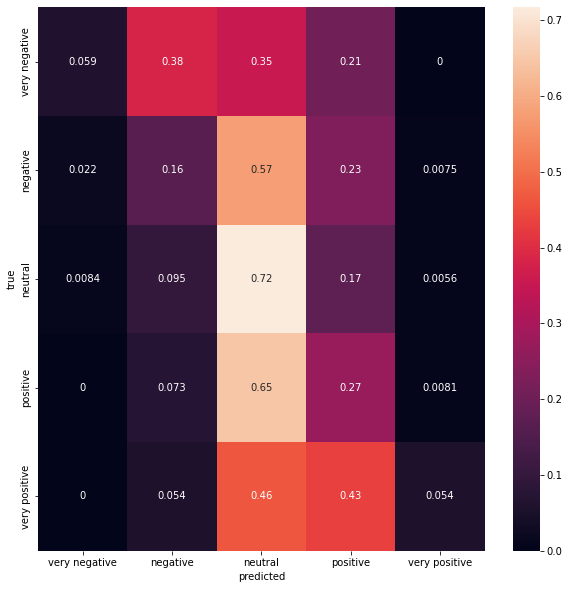

In [10]:
#above not great, maybe add in a regulariser?

#confusion matrix
matrix = confusion_matrix(y_test,clf.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("NB_confused.png")
plt.show()

In [15]:
# #random forest - grid search for optimal decision tree parameters -maybe try dif criterion
# rf_dic={
#     "n_estimators":[10,50,200,500],
#     "max_features": ["sqrt","log2"],
#     "criterion": ["gini"],
#     "max_depth": [4,8,30]
#     }

# rf = RandomForestClassifier(random_state=1)
# grid_search = GridSearchCV(estimator=rf,param_grid=rf_dic,cv=3)
# grid_search.fit(x_train,y_train)

# print("the best parameters are: " +str(grid_search.best_params_))

# print("accuracy: " + str(grid_search.best_estimator_.score(x_test, y_test)*100) + "%")

In [16]:
# #confusion matrix
# matrix = confusion_matrix(y_test,grid_search.best_estimator_.predict(x_test), normalize='true')

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.heatmap(matrix, annot=True) 
# ax.set_xticklabels(labels)
# ax.set_yticklabels(labels)
# ax.set_xlabel('predicted')
# ax.set_ylabel('true')
# # plt.savefig("RandForest_confused.png")
# plt.show()

In [80]:
#log reg

clf2 = LogisticRegression()
clf2.fit(x_train,y_train)
print(clf2.score(x_train,y_train))
print(clf2.score(x_test,y_test))

matrix2 = confusion_matrix(y_test,clf2.predict(x_test), normalize='true')


0.5808896029124808
0.5790337371494764


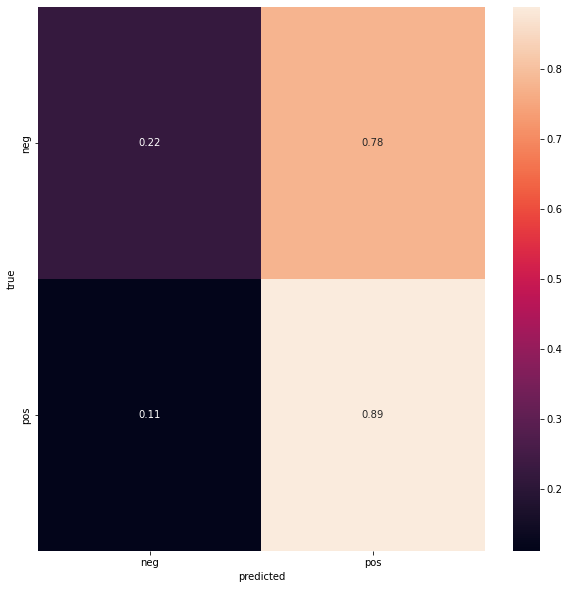

In [82]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix2, annot=True) 

# ax.set_xticklabels([0, 1, 2, 3, 4]) # ordinal
# ax.set_yticklabels([0, 1, 2, 3, 4]) # ordinal

ax.set_xticklabels(["neg", "pos"]) # binary
ax.set_yticklabels(["neg", "pos"]) # binary

ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("logreg_confused.png")
plt.show()

In [67]:
from sklearn.neural_network import MLPClassifier

clf_NN = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 5), random_state=1, max_iter=100000)

clf_NN.fit(x_train, y_train)
print(clf_NN.score(x_test, y_test))

0.5143105362227907


In [83]:
### binary labels

clf_NN2 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 5), random_state=1, max_iter=100000)

clf_NN2.fit(x_train, y_train)
print(clf_NN2.score(x_test, y_test))

0.6692729700596876


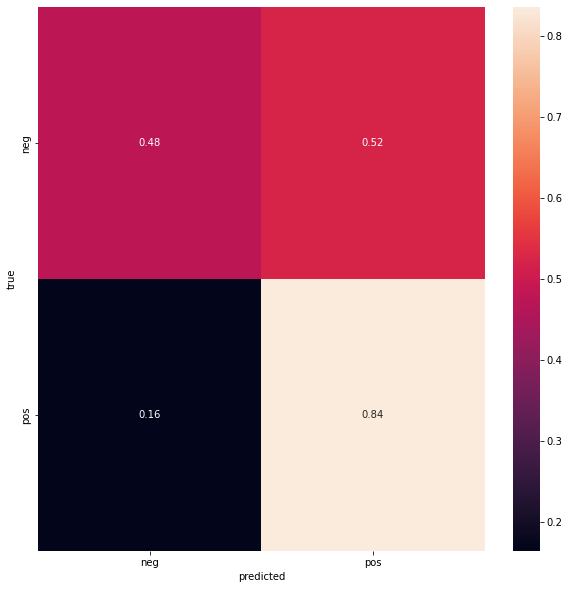

In [87]:
matrix3 = confusion_matrix(y_test,clf_NN2.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix3, annot=True) 

# ax.set_xticklabels(["vneg", "neg", "ntrl", "pos", "vpos"]) # ordinal
# ax.set_yticklabels(["vneg", "neg", "ntrl", "pos", "vpos"])

ax.set_xticklabels(["neg", "pos"]) # binary
ax.set_yticklabels(["neg", "pos"])

ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("NN_confusion.png")
plt.show()

In [9]:
import gensim

practice_model = gensim.models.Word2Vec.load('Word2vec_model')

In [58]:
practice_model.wv.most_similar("", topn=10)

[('old', 0.8885629177093506),
 ('world', 0.8878587484359741),
 ('many', 0.8871873617172241),
 ('might', 0.8868736028671265),
 ('better', 0.8855153918266296),
 ('self', 0.8842716813087463),
 ('heart', 0.8831278085708618),
 ('real', 0.8830533623695374),
 ('people', 0.8824098706245422),
 ('kind', 0.882049560546875)]